# Dynamic Programming Tracker for Hands
Implementation of  [Dreuw06 - Tracking Using Dynamic Programming
for Appearance-Based Sign Language Recognition](http://thomas.deselaers.de/publications/papers/dreuw_fg06.pdf)

## Imports

In [1]:
import os
import numpy as np
import skimage.io
import skimage
from scipy import ndimage
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as anim

from scipy.stats import multivariate_normal

import skvideo.io
import skvideo.datasets


## Score and penalty functions 

### Jump penalty functions

* p-norm between coordinates: $d(x_1,x_2)=||x_1-x_2||^p$

### Skin pixel scores
* Gaussian model

### Movement scores
* p-norm between frames

In [2]:
def jump_penalty_euclidean(p1,p2):
  d=p1-p2
  return np.sum(d**2)

def skin_pixel_scorer(video):
  T,h,w,c=video.shape
  score=np.zeros((T,h,w))
  mu_hsv=np.array([20.0,35.0,73.0])/255.0
  mu_rgb=np.array([176,134,112])
  cov=np.array([0.3,0.5,10])
  mu=mu_hsv

  for t in range(T):
    score[t,:,:]= multivariate_normal.pdf(video[t,:,:,:],mu,cov)
  score[score<0.001]=0
  score=ndimage.grey_erosion(score,(1, 10, 10))
  score= ndimage.gaussian_filter(score, sigma=(0,3,3), order=0)
  return score

def euclidean_movement_score(video):
  T,h,w,c=video.shape
  score=np.zeros((T-1,h,w))
  for t in range(T-1):
    delta=np.square(video[t+1,:,:,:]-video[t,:,:,:])
    score[t,:,:]= np.sqrt(np.sum(delta,axis=2))
    # if (t % 5==0):
    #   plt.clf()
    #   plt.imshow(score[t,:,:])
    #   plt.colorbar()
    #   plt.pause(0.1*1.0/60.0)
  return score

def manhattan_movement_score(video):
  T,h,w,c=video.shape
  score=np.zeros((T-1,h,w))
  structure = np.ones((2, 2))
  for t in range(T-1):
    delta=np.abs(video[t+1,:,:,:]-video[t,:,:,:])
    # delta= ndimage.gaussian_filter(delta, sigma=(3,3), order=0)
    # delta=ndimage.grey_erosion(delta,(2, 2))
    score[t, :, :]= np.sum(delta,axis=2)
    # if (t % 3==0):
    #   plt.clf()
    #   plt.imshow(score[t,:,:])
    #   plt.colorbar()
    #   plt.pause(0.1*1.0/60.0)
  score[score<0.002]=0
  score=ndimage.grey_erosion(score,(1, 20, 20))
  score= ndimage.gaussian_filter(score, sigma=(0,3,3), order=0)
  return score


## Misc utility stuff

In [3]:
def video_rgb_to_hsv(video):
  T=video.shape[0]
  for t in range(T):
    video[t,:,:,:]=matplotlib.colors.rgb_to_hsv(video[t,:]/255)


def video_hsv_to_rgb(video):
  T=video.shape[0]
  for t in range(T):
    video[t,:,:,:]=matplotlib.colors.hsv_to_rgb(video[t,:])*255


## Configuration


In [4]:
test_path='test_data/All_Blacks.5846.main_glosses.mb.r480x360.mp4'
tracked_video_path= "_tracked".join(os.path.splitext(test_path))
debug_video_path="_debug".join(os.path.splitext(test_path))
data = skvideo.io.ffprobe(test_path)['video']
rate = data['@r_frame_rate']

## Test model

In [5]:
class DPTracker:
  def __init__(self,neighbourhood_size):
    self.neighbourhood_size=neighbourhood_size

  def backtrack_path(self,backtracking_path,score):
    Tm,h,w,dim_indices=backtracking_path.shape
    T=Tm+1
    path=np.zeros((T,2),dtype=int) # 2 => (x,y)
    best_index_last_frame = np.argmax(score[-1,:,:])
    x,y= np.unravel_index(best_index_last_frame , score[-1,:,:].shape)
    path[-1,:]=np.array([x,y])
    for t in reversed(range(T-1)):
      x,y= tuple(path[t+1,:])
      path[t, :] = backtracking_path[t,x,y,:]
    return path
        
  def track(self,video,movement_scorer,movement_vs_pixel_weight,pixel_scorer,jump_penalty,jump_penalty_weight):
    video = ndimage.gaussian_filter(video, sigma=(0, 2, 2, 0), order=0)
    T,h,w,c=video.shape
    self.backtracking_path=np.zeros((T-1,h,w,2),dtype=int) # 2 => (x,y) for T-1
    self.score=np.zeros((T,h,w))
    self.movement_score=movement_scorer(video)
    self.pixel_score=pixel_scorer(video)
    n=self.neighbourhood_size
    n2=n+1
    self.jump_penalty_matrix=jump_penalty_weight*self.generate_jump_penalty_matrix(jump_penalty,n)
    self.score[0,:,:]=self.pixel_score[0,:,:]
    self.local_score = movement_vs_pixel_weight * self.movement_score + \
                 (1 - movement_vs_pixel_weight) * self.pixel_score[1:, :, :]
        
    for t in range(T-1):
      for i in range(h):
        for j in range(w):
            self.backtracking_path[t,i,j,:]=np.array([i,j])
            
    for t in range(1,T):
      print("Calculating score for frame %d / %d " % (t,T-1))
      for i in range(n, h-n):
        for j in range(n, w-n):
          neighbourhood_score=self.local_score[t-1,i-n:i+n2,j-n:j+n2]
          previous_score=neighbourhood_score-self.jump_penalty_matrix

          index=np.argmax(previous_score)
          best_score=previous_score.flat[index]
          relative_x,relative_y=np.unravel_index(index, self.jump_penalty_matrix.shape)
          x = i + relative_x - n
          y = j + relative_y - n
          self.backtracking_path[t-1, i, j, :] =np.array([x,y])
          self.score[t,i,j]=self.local_score[t-1,i,j]+np.mean(previous_score) #best_score
    self.path=self.backtrack_path(self.backtracking_path,self.score)
    
    return self.path

  def generate_jump_penalty_matrix(self, jump_penalty, neighbourhood):
    n=neighbourhood*2+1
    matrix=np.zeros((n,n))
    center=np.array([neighbourhood,neighbourhood])
    for i in range(n):
      for j in range(n):
        position=np.array([i,j])
        matrix[i,j]=jump_penalty(center,position)
    return matrix



video = skvideo.io.vread(test_path).astype(float)
print(video.shape)
video=video[1:-1:1,:,:,:]
video_rgb_to_hsv(video)

T,h,w,c=video.shape
neighbourhood_size=60
movement_vs_pixel_weight=0.2
jump_penalty_weight=0.00
tracker=DPTracker(neighbourhood_size)
track_result=tracker.track(video,manhattan_movement_score,movement_vs_pixel_weight,skin_pixel_scorer,
                         jump_penalty_euclidean,jump_penalty_weight)

print(track_result.T)
video_hsv_to_rgb(video)

(54, 368, 480, 3)
Calculating score for frame 1 / 51 
Calculating score for frame 2 / 51 
Calculating score for frame 3 / 51 
Calculating score for frame 4 / 51 
Calculating score for frame 5 / 51 
Calculating score for frame 6 / 51 
Calculating score for frame 7 / 51 
Calculating score for frame 8 / 51 
Calculating score for frame 9 / 51 
Calculating score for frame 10 / 51 
Calculating score for frame 11 / 51 
Calculating score for frame 12 / 51 
Calculating score for frame 13 / 51 
Calculating score for frame 14 / 51 
Calculating score for frame 15 / 51 
Calculating score for frame 16 / 51 
Calculating score for frame 17 / 51 
Calculating score for frame 18 / 51 
Calculating score for frame 19 / 51 
Calculating score for frame 20 / 51 
Calculating score for frame 21 / 51 
Calculating score for frame 22 / 51 
Calculating score for frame 23 / 51 
Calculating score for frame 24 / 51 
Calculating score for frame 25 / 51 
Calculating score for frame 26 / 51 
Calculating score for frame 2

## Save output

In [11]:
def draw_tracked(video,track_result):
  T = video.shape[0]
  for t in range(T):
    x,y=tuple(track_result[t,:])
    rr,cc,val=circle_perimeter_aa(x,y,3)
    video[t,rr,cc,:]=255
  return video


def generate_debug_video(video,tracker,debug_video_path):
#   FFMpegWriter= anim.writers['ffmpeg']
  metadata=dict(title="Output")
#   writer=FFMpegWriter(fps=6,bitrate=16384*2,metadata=metadata)
  title_fontsize=10
  f,((image_ax,movement_ax),(pixel_ax,score_ax))=plt.subplots(2,2,dpi=100)
  f.set_size_inches(10,10, True)
  image_ax.set_title("Frame",fontsize=title_fontsize)
  movement_ax.set_title("movement",fontsize=title_fontsize)
  pixel_ax.set_title("pixel",fontsize=title_fontsize)
  score_ax.set_title("score",fontsize=title_fontsize)
  T,h,w,c=video.shape
  base_file,ext=os.path.splitext(debug_video_path)
#   with writer.saving(f,debug_video_path,T):
  for t in range(T):
    image_ax.cla()
    pixel_ax.cla()
    score_ax.cla()
    movement_ax.cla()
    plt.suptitle("Frame %d/%d" % (t,T-1))
    image_ax.imshow(video[t,:,:,:])
    pixel_plot=pixel_ax.imshow(tracker.pixel_score[t,:,:])


    if t==0:
      cbar=f.colorbar(pixel_plot, ax=pixel_ax)
      cbar.ax.tick_params(labelsize=10) 
    if t>0:
      movement_plot=movement_ax.imshow(tracker.movement_score[t-1,:,:])
      score_plot=score_ax.imshow(tracker.local_score[t-1,:,:])
    if t==1:
      cbar=f.colorbar(movement_plot, ax=movement_ax)
      cbar.ax.tick_params(labelsize=10) 
      cbar=f.colorbar(score_plot, ax=score_ax)
      cbar.ax.tick_params(labelsize=10) 
    a='%s_%03d.png' % (base_file,t)
    plt.savefig(a)
#       writer.grab_frame()

tracked_video=draw_tracked(video,track_result)
tracked_video=tracked_video.astype('short')
generate_debug_video(tracked_video, tracker, debug_video_path)

skvideo.io.vwrite(tracked_video_path, tracked_video, outputdict={
  '-vcodec': 'libx264',
  '-pix_fmt': 'yuv420p',
  '-r': rate,
})
plt.close("all")

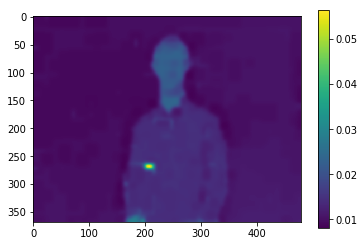

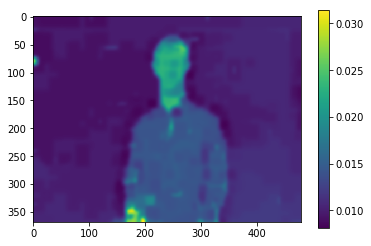

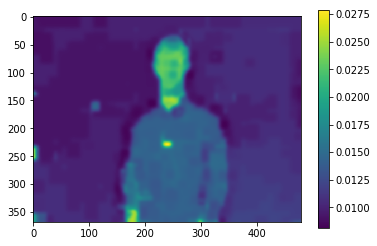

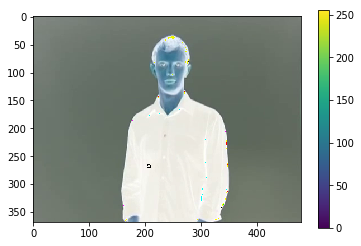

In [32]:
score=tracker.local_score
plt.imshow(score[T-2,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-3,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-4,:,:])
plt.colorbar()
plt.figure()
plt.imshow(tracked_video[T-1,:,:,:])
plt.colorbar()
plt.show()